In [59]:
import h5py
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib.colors as colors
import matplotlib.colorbar as colorbar
from mpl_toolkits.axes_grid1 import make_axes_locatable
from scipy.spatial import KDTree
from tqdm import tqdm

In [19]:
d = {}
with h5py.File(r'C:\Users\willd\Documents\Georgia Tech\CSE6424\Project\nearest_nyc.hdf5', 'r') as h5:
    for k in h5.keys():
        d[k] = h5[k][:]

In [20]:
health_df = pd.read_csv(r'C:\Users\willd\Documents\Georgia Tech\CSE6424\Project\PLACES__Census_Tract_Data__GIS_Friendly_Format___2021_release.csv')
health_df['x'] = health_df['Geolocation'].map(lambda x: x.replace('POINT', '').replace(')', '').replace('(', '').split()[0]).astype(np.float32)
health_df['y'] = health_df['Geolocation'].map(lambda x: x.replace('POINT', '').replace(')', '').replace('(', '').split()[1]).astype(np.float32)

In [60]:
health_df.columns

Index(['StateAbbr', 'StateDesc', 'CountyName', 'CountyFIPS', 'TractFIPS',
       'TotalPopulation', 'ACCESS2_CrudePrev', 'ACCESS2_Crude95CI',
       'ARTHRITIS_CrudePrev', 'ARTHRITIS_Crude95CI', 'BINGE_CrudePrev',
       'BINGE_Crude95CI', 'BPHIGH_CrudePrev', 'BPHIGH_Crude95CI',
       'BPMED_CrudePrev', 'BPMED_Crude95CI', 'CANCER_CrudePrev',
       'CANCER_Crude95CI', 'CASTHMA_CrudePrev', 'CASTHMA_Crude95CI',
       'CERVICAL_CrudePrev', 'CERVICAL_Crude95CI', 'CHD_CrudePrev',
       'CHD_Crude95CI', 'CHECKUP_CrudePrev', 'CHECKUP_Crude95CI',
       'CHOLSCREEN_CrudePrev', 'CHOLSCREEN_Crude95CI',
       'COLON_SCREEN_CrudePrev', 'COLON_SCREEN_Crude95CI', 'COPD_CrudePrev',
       'COPD_Crude95CI', 'COREM_CrudePrev', 'COREM_Crude95CI',
       'COREW_CrudePrev', 'COREW_Crude95CI', 'CSMOKING_CrudePrev',
       'CSMOKING_Crude95CI', 'DENTAL_CrudePrev', 'DENTAL_Crude95CI',
       'DEPRESSION_CrudePrev', 'DEPRESSION_Crude95CI', 'DIABETES_CrudePrev',
       'DIABETES_Crude95CI', 'GHLTH_CrudePre

In [43]:
health_df['dist'] = np.nan
for k in d.keys():
    health_df[k] = np.nan

In [46]:
points = np.array([d['nodes_x'], d['nodes_y']]).T
tree = KDTree(points)
dist, idx = tree.query((d['nodes_x'][200], d['nodes_y'][200]))
print((d['nodes_x'][200], d['nodes_y'][200]), d['nodes_x'][idx], d['nodes_y'][idx], d['nodes'][idx])

(-74.73972, 40.915054) -74.73972 40.915054 2351045561


In [47]:
# Find the nearest NYC node to each health datapoint
for row in tqdm(health_df.itertuples(), total=health_df.shape[0]):
    dist, idx = tree.query((row.x, row.y))
    health_df.at[row.Index, 'dist'] = dist
    for k in d.keys():
        health_df.at[row.Index, k] = d[k][idx]

100%|██████████████████████████████████████████████████████████████████████████| 72337/72337 [00:26<00:00, 2701.65it/s]


In [54]:
# Only keep the datapoint match that has the smallest distance
nyc_health = health_df.loc[health_df.groupby('nodes')['dist'].idxmin()]

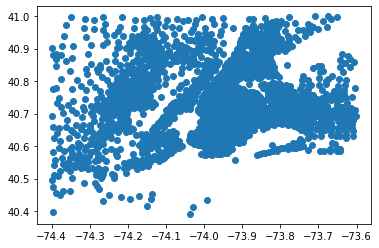

In [69]:
x = nyc_health['x'].to_numpy()
y = nyc_health['y'].to_numpy()
smaller_bounds = (x > -74.4) & (x < -73.6) & (y < 41)
plt.scatter(x[smaller_bounds], y[smaller_bounds])

In [58]:
nyc_health.to_csv(r'C:\Users\willd\Documents\Georgia Tech\CSE6424\Project\nyc_health.csv', index=False)

In [61]:
def normalize(x, min_, max_):
    return (x - min_)/(max_ - min_)

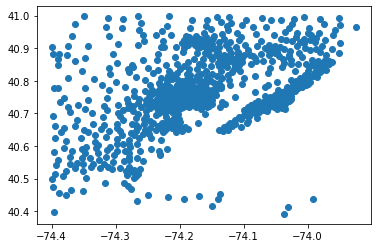

In [80]:
z = np.asarray(nyc_health['CANCER_CrudePrev'], dtype=np.float32)
bounds_z = smaller_bounds & np.isnan(z)
plt.scatter(x[bounds_z], y[bounds_z])

C:\Users\willd\AppData\Local\Temp\ipykernel_5160\4205141695.py:19: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  plt.figure()


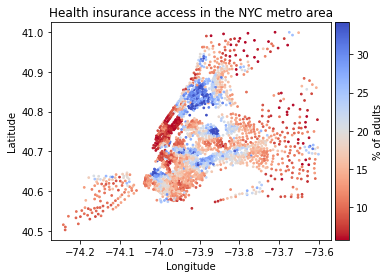

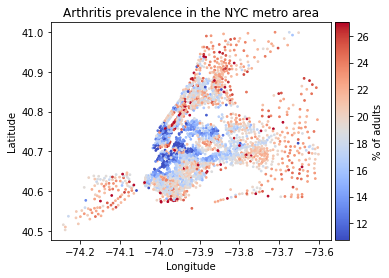

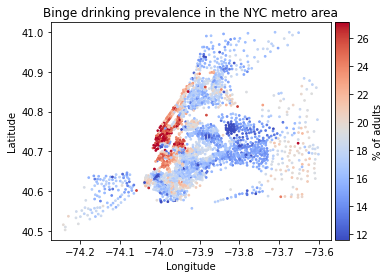

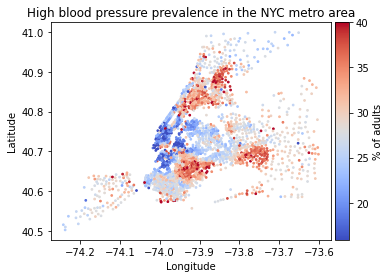

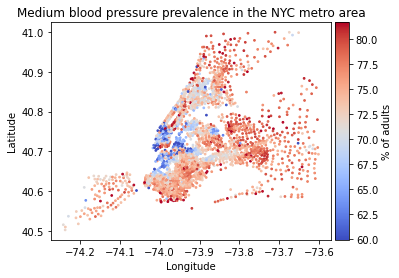

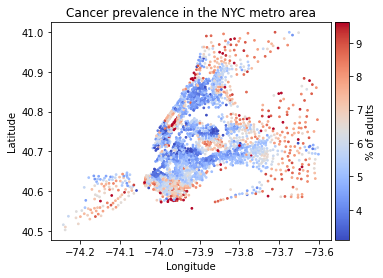

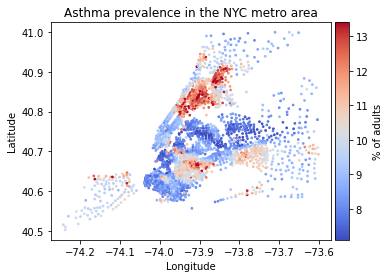

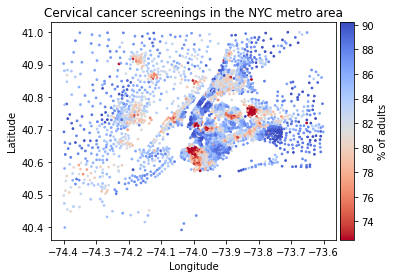

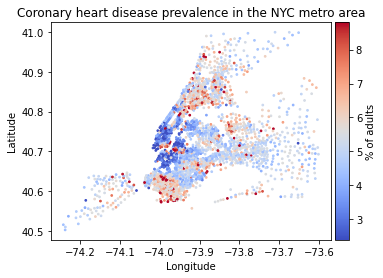

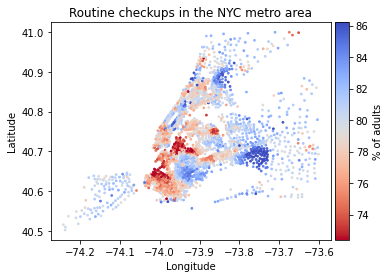

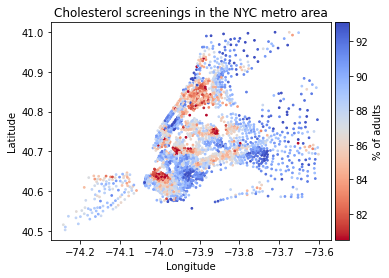

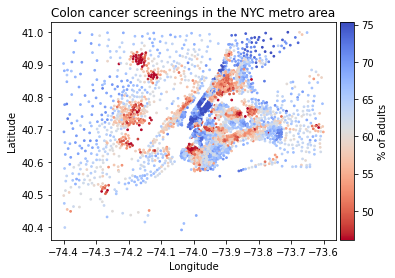

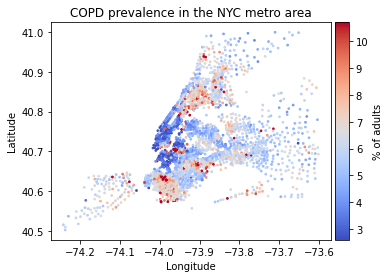

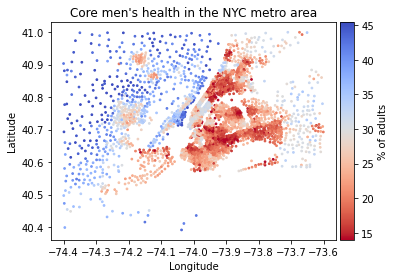

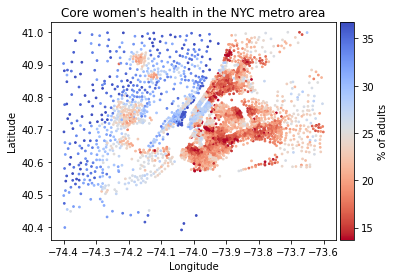

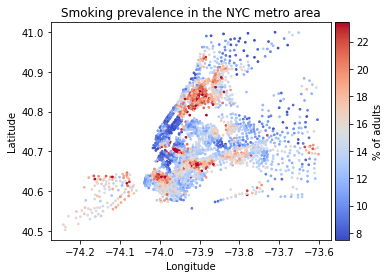

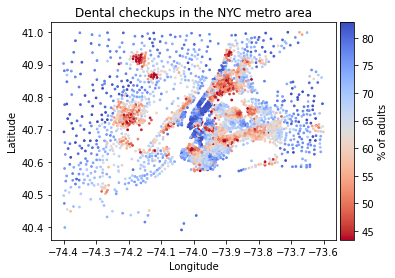

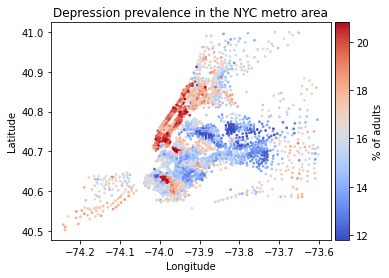

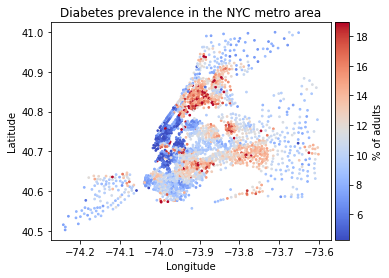

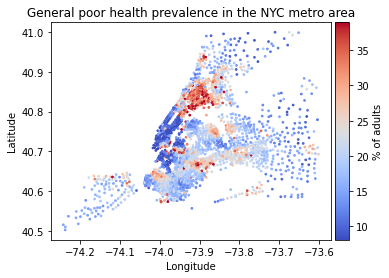

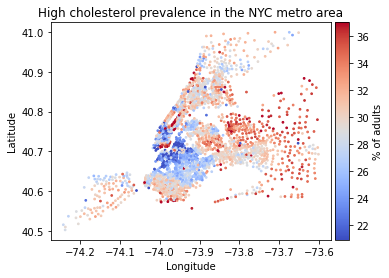

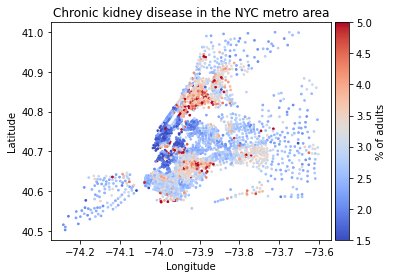

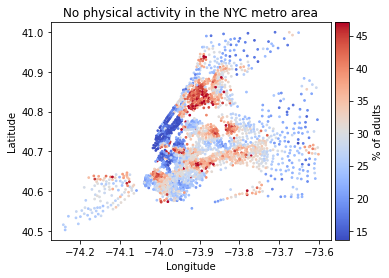

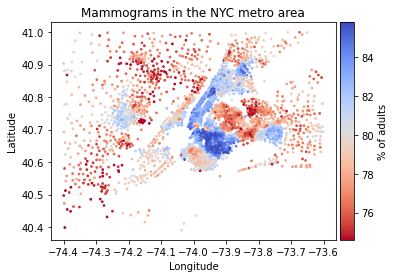

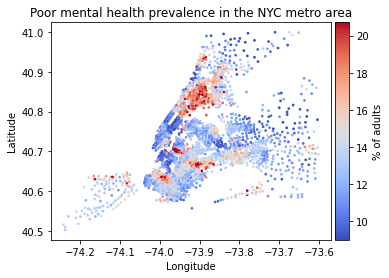

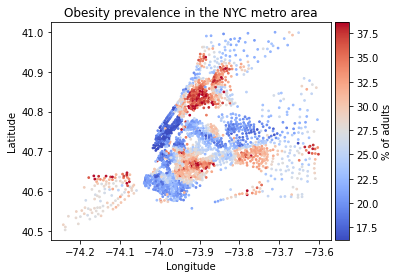

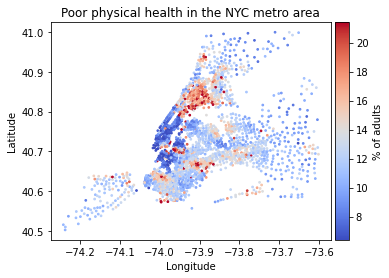

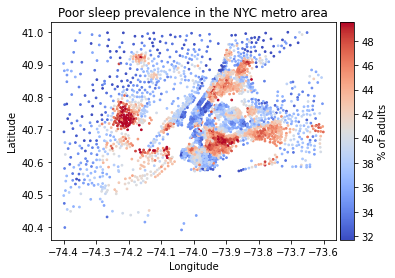

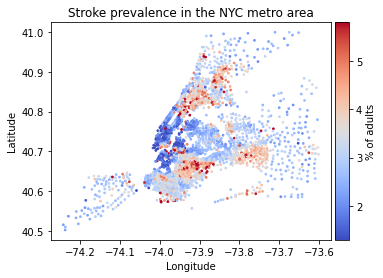

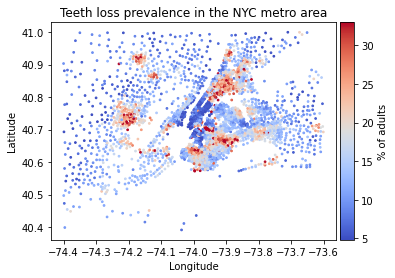

In [90]:
name_mapping = {'access2': 'Health insurance access', 'arthritis': 'Arthritis prevalence', 'binge': 'Binge drinking prevalence',
               'bphigh': 'High blood pressure prevalence', 'bpmed': 'Medium blood pressure prevalence', 'cancer': 'Cancer prevalence',
               'casthma': 'Asthma prevalence', 'cervical': 'Cervical cancer screenings', 'chd': 'Coronary heart disease prevalence',
               'checkup': 'Routine checkups', 'cholscreen': 'Cholesterol screenings', 'colon_screen': 'Colon cancer screenings',
               'copd': 'COPD prevalence', 'corem': 'Core men\'s health', 'corew': 'Core women\'s health', 'csmoking': 'Smoking prevalence',
               'dental': 'Dental checkups', 'depression': 'Depression prevalence', 'diabetes': 'Diabetes prevalence', 'ghlth': 'General poor health prevalence',
               'highchol': 'High cholesterol prevalence', 'kidney': 'Chronic kidney disease', 'lpa': 'No physical activity', 'mammouse': 'Mammograms',
               'mhlth': 'Poor mental health prevalence', 'obesity': 'Obesity prevalence', 'phlth': 'Poor physical health', 'sleep': 'Poor sleep prevalence',
               'stroke': 'Stroke prevalence', 'teethlost': 'Teeth loss prevalence'}
good = {'access2', 'cervical', 'checkup', 'colon_screen', 'cholscreen', 'corem' , 'corew', 'dental', 'mammouse'}
for c in nyc_health.columns:
    if c.endswith('CrudePrev'):
        cancer = np.asarray(nyc_health[c], dtype=np.float32)
        cancer_bounds = smaller_bounds & ~np.isnan(cancer)
        cancer = cancer[cancer_bounds]
        min_cancer = np.quantile(cancer, 0.02)
        max_cancer = np.quantile(cancer, 0.98)
        # See https://stackoverflow.com/a/18195921 for figure positioning
        plt.figure()
        ax = plt.gca()
        ax.scatter(x[cancer_bounds], y[cancer_bounds], c=[(cm.coolwarm if c[:-10].lower() not in good else cm.coolwarm_r)(normalize(x, min_cancer, max_cancer)) for x in cancer], s=3)
        ax.set_title('{} in the NYC metro area'.format(name_mapping[c[:-10].lower()]))
        ax.set_ylabel('Latitude')
        ax.set_xlabel('Longitude')
        ax.set_aspect('equal')
        divider = make_axes_locatable(ax)
        cax = divider.append_axes("right", size="5%", pad=0.05)
        cmap = cm.coolwarm if c[:-10].lower() not in good else cm.coolwarm_r
        norm = colors.Normalize(vmin=min_cancer, vmax=max_cancer)
        cb1 = colorbar.ColorbarBase(cax, cmap=cmap, norm=norm, orientation='vertical', label='% of adults')
        plt.savefig(r'C:\Users\willd\Documents\Georgia Tech\CSE6424\Project\nyc_{}.png'.format(name_mapping[c[:-10].lower()]), dpi=300)